:<img src="https://raw.githubusercontent.com/HooshBaaz/2022_DataAnalytics_SummerSchool/main/assets/logo3.png" width="200" height="200" >

<div style="display:block"><br><br>
    <div style="display:block" align=left display=block> 
        <font size=5><b>Day8 - HandsOn2: text classification </b></font><br>
        <hr/>

</div>

<pre>

├── Using Pretrained PArsBERT for text CLassification
 
</pre>

Classification is one of the most important tasks in Supervised Machine Learning, and this algorithm is being used in multiple domains for different use cases. Now let’s discuss one such use case, i.e. Text classification.

You can see the below picture for the classification architecture using BERT.

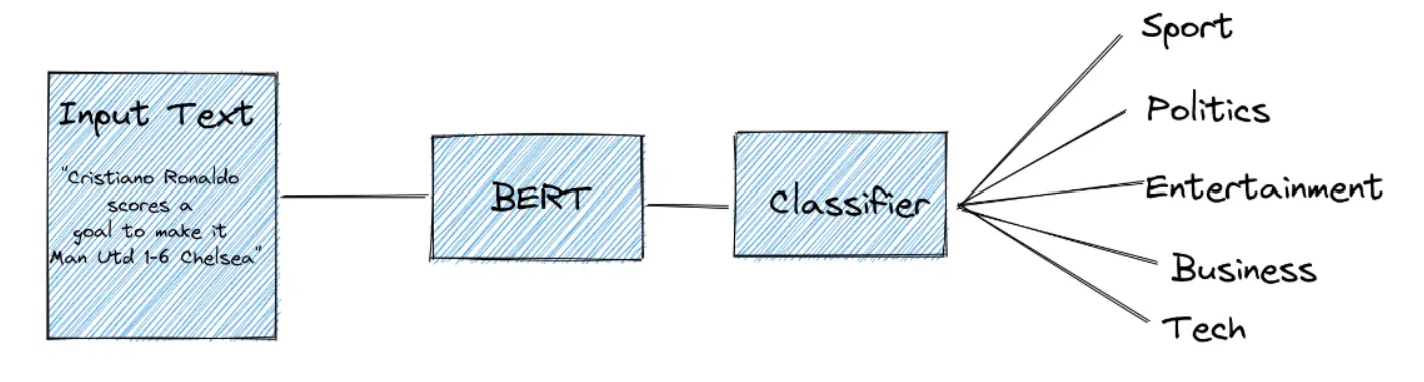

### Import Modules/Libraries

Let’s get started by installing the transformers and the datasets libraries,

In [ ]:
!pip install datasets transformers evaluate

In [ ]:
import numpy  as np
import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In this tutorial, we will perform sentiment analysis on user comments from **Snappfood**, an online food delivery company. The dataset consists of 70,000 comments with two labels: "1" for "Happy" and "0 for""Sad." Our goal is to build a text classification model using ParsBERT to automatically classify user comments based on their sentiment.

In [ ]:
# read test and trian data and use Dataset library 
data = DatasetDict()
data['train'] = Dataset.from_pandas(pd.read_csv("train.csv", usecols = ['comment', 'label'], on_bad_lines='skip'))
data['test'] = Dataset.from_pandas(pd.read_csv("test.csv", usecols = ['comment', 'label'], on_bad_lines='skip'))

In [ ]:
# convert dict to dataframe to show
pd.DataFrame(data['train'])

In [ ]:
data

## bert model

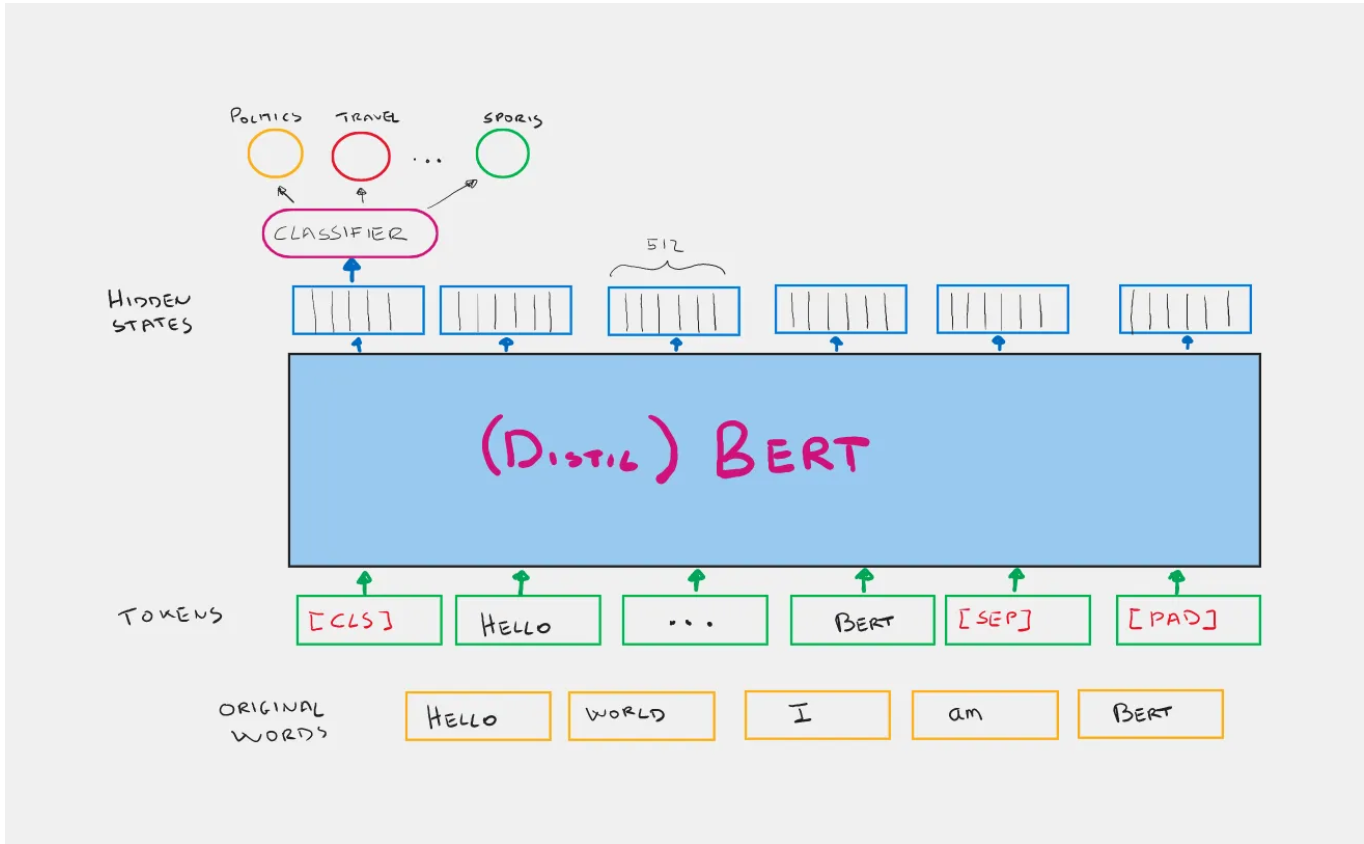


**Tokenization** is an essential step in natural language processing (NLP) where text data is converted into numerical arrays using vocabulary mapping.

- There are various tokenization methods, including word-based, character-based, and sub-word based tokenization.

HuggingFace's AutoTokenizer class is a popular choice for tokenization, utilizing pre-trained tokenizers from different models. 

It is crucial to ensure that the tokenizer and model checkpoint are compatible for consistent tokenization. For example, when fine-tuning the ParsBert model on the snapfood dataset, the tokenizer and model weights can be accessed through the HuggingFace library using the model name.

 Importing the tokenizer can be done with the AutoTokenizer module.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

HuggingFace will automatically download and cache the tokeniser locally. Now let's see how the tokeniser works with an example,

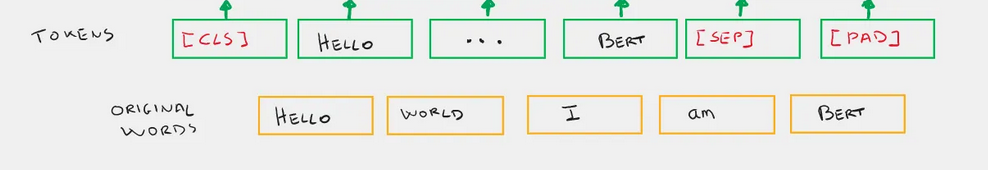

In [ ]:
text = "یه کم خشک بود ولی در مجموع خوشمزه بود"
output = tokenizer(text)
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
print(f"Tokenized output: {output}")
print(f"Tokenized tokens: {tokens}")
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Since we have seen how the tokeniser works, let’s now tokenise the entire dataset.

In [ ]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["comment"], padding=True, truncation=True)
# Tokenize entire dataset 
tokenized_dataset = data.map(tokenize, batched=True, batch_size=None)

Great! We can print the dataset and check that extra fields, i.e. input_ids and attention_mask have been added. Now we are ready for the final step, i.e. training the text classifier.

In [ ]:
pd.DataFrame(tokenized_dataset['train'])

**Training the Text Classifier:**

Let’s start by importing the TFAutoModelForSequenceClassification method from the transformers library. This will automatically download and cache the model provided with the checkpoint name. Since we have defined the checkpoint while downloading the tokeniser, we should also use the same to download the model.

In [ ]:
from transformers import TFAutoModelForSequenceClassification
num_labels = 2
model = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", 
                                                             num_labels=num_labels)

To train the ParsBert Model with the attached model head for 2-label classification, we need to prepare the data using Tensorflow. Before feeding token IDs into the model, we batch the dataset and ensure equal sample lengths. HuggingFace's DataCollator performs automatic padding for batched samples, with the input size equal to the maximum sample length.

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

Now let’s create the TensorFlow datasets from the tokenised dataset,

In [ ]:
# Create tf datasets 
BAtch_Size = 8
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns= ['input_ids', 'token_type_ids', 'attention_mask', 'label'], 
    label_cols=["label"], 
    shuffle=True, 
    batch_size=BAtch_Size,
    collate_fn=data_collator
)
tf_valid_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'], 
    label_cols=["label"], 
    shuffle=False, 
    batch_size=BAtch_Size,
    collate_fn=data_collator
)

We are ready to proceed with model training. Before that, let’s do the necessary imports,

In [ ]:
# Imports
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses

Compile the model with Adam optimiser, SparseCategoricalCrossEntropy loss function and SparseCategoricalAccuracy as the metric.

In [ ]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=metrics.SparseCategoricalAccuracy()
)

Now finally, let’s fit the model for 5 epochs,



In [ ]:
# Fit the model
history = model.fit(tf_train_dataset, 
          validation_data=tf_valid_dataset, 
          epochs=5)

Great! Now we have trained our model for 5 epochs. Now let’s test the model on some sentences.

In [ ]:
text = 'غذا گرم رسید کیفیت و پخت گوشت عالی بود'
out = tokenizer(text)["input_ids"]
inputs = tokenizer(text, return_tensors="tf")

In [ ]:
logits =  model(inputs).logits
int(tf.math.argmax(logits, axis=-1)[0])

1

It shows the HAPPY label !

###  💭 Now
- download the following dataset 
- load it and use it as test dataset. Plot ROC curve for it. 
- compare this with previouse results on snapfood dataset.

In [ ]:
!wget https://github.com/Arminkhayati/Digikala-comments-sentiment-analysis/raw/main/data.xls